# Catch The Players with ML Classification on Scotium Dataset
Predicting the class (average, highlighted) of players based on the ratings given to the characteristics of football players followed by scouts. <br>
**About Dataset** <br>
*scoutium_attributes.csv;* <br>
* task_response_id: A set of evaluations by a scout on all the players in a team's squad during a match.
* match_id
* evaluator_id
* player_id
* position_id: The ID of the position played by the relevant player in that match.
    1. Goalkeeper (GK)
    2. Defender (DF)
    3. Right-back (RB)
    4. Left-back (LB)
    5. Defensive midfielder (DM)
    6. Central midfielder (CM)
    7. Right winger (RW)
    8. Left winger (LW)
    9. Attacking midfielder (AM)
    10. Forward (FW)
* analysis_id: A set of characteristic evaluations by a scout on a player during a match.
* attribute_id: The ID of each characteristic that the players are evaluated on.
* attribute_value: The value (score) given by a scout to a characteristic of a player.

*scoutium_potential_labels.csv;* <br>
* task_response_id
* match_id
* evaluator_id
* player_id
* potential_label: "A label (target variable) that specifies the final decision of a scout about a player during a match.

## Load Datasets

In [1]:
import pandas as pd

In [2]:
attr = pd.read_csv("datasets/scoutium_attributes.csv", sep=';')
pot = pd.read_csv("datasets/scoutium_potential_labels.csv", sep=';')

In [3]:
attr.head(5)

,task_response_id,match_id,evaluator_id,player_id,position_id,analysis_id,attribute_id,attribute_value
0,4915,62935,177676,1361061,2,12818495,4322,56.0
1,4915,62935,177676,1361061,2,12818495,4323,56.0
2,4915,62935,177676,1361061,2,12818495,4324,67.0
3,4915,62935,177676,1361061,2,12818495,4325,56.0
4,4915,62935,177676,1361061,2,12818495,4326,45.0


In [4]:
pot.head(5)

,task_response_id,match_id,evaluator_id,player_id,potential_label
0,4915,62935,177676,1361061,average
1,4915,62935,177676,1361626,highlighted
2,4915,62935,177676,1361858,average
3,4915,62935,177676,1362220,highlighted
4,4915,62935,177676,1364951,highlighted


### Merge Datasets

In [5]:
df = pd.merge(attr, pot, on=["task_response_id", 'match_id', 'evaluator_id', "player_id"])

In [6]:
df.head(5)

,task_response_id,match_id,evaluator_id,player_id,position_id,analysis_id,attribute_id,attribute_value,potential_label
0,4915,62935,177676,1361061,2,12818495,4322,56.0,average
1,4915,62935,177676,1361061,2,12818495,4323,56.0,average
2,4915,62935,177676,1361061,2,12818495,4324,67.0,average
3,4915,62935,177676,1361061,2,12818495,4325,56.0,average
4,4915,62935,177676,1361061,2,12818495,4326,45.0,average


## Data Preparation 
We can handle the positions. It is possible to remove goolkeepers because company want to find player from the other positions.

In [7]:
df = df[df['position_id'] != 1]

Let's look the target feature deeper.

In [8]:
df.groupby('potential_label').agg({'potential_label': ['count']})

,potential_label
,count
potential_label,
average,7922
below_average,136
highlighted,1972


'below_average' class is so low in datasets. It is possible to remove this class for business problem.

In [9]:
df = df[df['potential_label'] != 'below_average']

### Pivot Table

In [10]:
pivot_df = df.pivot_table(index=['player_id', 'position_id', 'potential_label'],
                           columns=['attribute_id'],
                           values=['attribute_value']).reset_index()

In [11]:
pivot_df.rename(columns={col: str(col) for col in pivot_df.columns}, inplace=True)

In [12]:
pivot_df.head()

player_id position_id potential_label  ... attribute_value            
attribute_id                                        ...            4408  4423  4426
0              1355710           7         average  ...            34.0  34.0  56.0
1              1356362           9         average  ...            67.0  56.0  78.0
2              1356375           3         average  ...            67.0  56.0  78.0
3              1356375           4         average  ...            67.0  45.0  56.0
4              1356411           9         average  ...            56.0  67.0  78.0

[5 rows x 37 columns]

### Encoding

In [20]:
from _encoders_utils import label_encoder

binary_cols = ['potential_label']

In [21]:
pivot_df = label_encoder(pivot_df, binary_cols)

2023-04-16 05:43:43,061 - logging_utils - DEBUG - label_encoder function is executing...
2023-04-16 05:43:43,063 - logging_utils - INFO - potential_label column is encoding...


In [22]:
pivot_df.head()

player_id position_id potential_label  ... attribute_value            
attribute_id                                        ...            4408  4423  4426
0              1355710           7               0  ...            34.0  34.0  56.0
1              1356362           9               0  ...            67.0  56.0  78.0
2              1356375           3               0  ...            67.0  56.0  78.0
3              1356375           4               0  ...            67.0  45.0  56.0
4              1356411           9               0  ...            56.0  67.0  78.0

[5 rows x 37 columns]

### Scaling

In [25]:
from _eda_utils import seperate_columns

In [43]:
_types = [str(_type) for _type in pivot_df.dtypes]
columns = list(pivot_df.columns)

numeric_cols, categoric_cols = seperate_columns(zip(columns, _types))

2023-04-16 05:53:12,991 - logging_utils - DEBUG - seperate_columns function executing...
2023-04-16 05:53:12,992 - logging_utils - INFO - 
Numerical Columns: [('attribute_value', 4408), ('attribute_value', 4353), ('attribute_value', 4356), ('attribute_value', 4423), ('attribute_value', 4426), ('attribute_value', 4322), ('attribute_value', 4328), ('attribute_value', 4325), ('attribute_value', 4340), ('attribute_value', 4343), ('attribute_value', 4407), ('attribute_value', 4352), ('attribute_value', 4349), ('attribute_value', 4355), ('attribute_value', 4324), ('attribute_value', 4327), ('position_id', ''), ('attribute_value', 4333), ('attribute_value', 4330), ('player_id', ''), ('attribute_value', 4342), ('attribute_value', 4339), ('attribute_value', 4345), ('attribute_value', 4348), ('attribute_value', 4354), ('attribute_value', 4351), ('attribute_value', 4357), ('attribute_value', 4326), ('attribute_value', 4323), ('attribute_value', 4329), ('attribute_value', 4335), ('attribute_value'

In [47]:
numeric_cols = [col for col in numeric_cols
                if col not in [('position_id', ''), ('player_id', ''), ('potential_label', '')]]

In [55]:
target_col = ('potential_label', '')

In [48]:
numeric_cols

[('attribute_value', 4408),
 ('attribute_value', 4353),
 ('attribute_value', 4356),
 ('attribute_value', 4423),
 ('attribute_value', 4426),
 ('attribute_value', 4322),
 ('attribute_value', 4328),
 ('attribute_value', 4325),
 ('attribute_value', 4340),
 ('attribute_value', 4343),
 ('attribute_value', 4407),
 ('attribute_value', 4352),
 ('attribute_value', 4349),
 ('attribute_value', 4355),
 ('attribute_value', 4324),
 ('attribute_value', 4327),
 ('attribute_value', 4333),
 ('attribute_value', 4330),
 ('attribute_value', 4342),
 ('attribute_value', 4339),
 ('attribute_value', 4345),
 ('attribute_value', 4348),
 ('attribute_value', 4354),
 ('attribute_value', 4351),
 ('attribute_value', 4357),
 ('attribute_value', 4326),
 ('attribute_value', 4323),
 ('attribute_value', 4329),
 ('attribute_value', 4335),
 ('attribute_value', 4332),
 ('attribute_value', 4338),
 ('attribute_value', 4341),
 ('attribute_value', 4344),
 ('attribute_value', 4350)]

In [52]:
from _scaling_utils import standart_scaler

In [53]:
standart_scaler(pivot_df, numeric_cols)

2023-04-16 06:06:00,121 - logging_utils - DEBUG - standart_scaler function is executing...
2023-04-16 06:06:00,122 - logging_utils - INFO - ('attribute_value', 4408) is scaling...
2023-04-16 06:06:00,129 - logging_utils - INFO - ('attribute_value', 4353) is scaling...
2023-04-16 06:06:00,137 - logging_utils - INFO - ('attribute_value', 4356) is scaling...
2023-04-16 06:06:00,142 - logging_utils - INFO - ('attribute_value', 4423) is scaling...
2023-04-16 06:06:00,149 - logging_utils - INFO - ('attribute_value', 4426) is scaling...
2023-04-16 06:06:00,154 - logging_utils - INFO - ('attribute_value', 4322) is scaling...
2023-04-16 06:06:00,162 - logging_utils - INFO - ('attribute_value', 4328) is scaling...
2023-04-16 06:06:00,168 - logging_utils - INFO - ('attribute_value', 4325) is scaling...
2023-04-16 06:06:00,174 - logging_utils - INFO - ('attribute_value', 4340) is scaling...
2023-04-16 06:06:00,181 - logging_utils - INFO - ('attribute_value', 4343) is scaling...
2023-04-16 06:06:00

player_id position_id  ... attribute_value          
attribute_id                        ...            4423      4426
0              1355710           7  ...       -0.955381 -0.252741
1              1356362           9  ...        0.403717  1.041611
2              1356375           3  ...        0.403717  1.041611
3              1356375           4  ...       -0.275832 -0.252741
4              1356411           9  ...        1.083267  1.041611
..                 ...         ...  ...             ...       ...
266            1907347           5  ...        1.762816 -0.252741
267            1907347           6  ...        1.083267  1.041611
268            1909532          10  ...       -0.955381 -2.194269
269            1909724           2  ...        1.083267  1.041611
270            1909728           7  ...        1.083267  1.041611

[271 rows x 37 columns]

## Model Selection

In [60]:
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split

X = pivot_df[numeric_cols]
y = pivot_df[[target_col]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [61]:
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)

In [62]:
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

100%|██████████| 29/29 [00:01<00:00, 21.11it/s]


In [63]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
PassiveAggressiveClassifier,0.80,0.79,0.79,0.81,0.02
LinearSVC,0.80,0.76,0.76,0.81,0.04
LGBMClassifier,0.87,0.73,0.73,0.85,0.07
LinearDiscriminantAnalysis,0.78,0.72,0.72,0.79,0.06
Perceptron,0.78,0.72,0.72,0.79,0.03
LogisticRegression,0.80,0.71,0.71,0.80,0.03
BaggingClassifier,0.82,0.70,0.70,0.81,0.04
SGDClassifier,0.76,0.69,0.69,0.77,0.02
DecisionTreeClassifier,0.76,0.69,0.69,0.77,0.02


## LGBMClassifier

In [64]:
import warnings
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV, cross_validate

warnings.simplefilter(action='ignore', category=Warning)

In [91]:
def get_scores(model, X, y, cv=5, scoring=["roc_auc", "f1", "precision", "recall", "accuracy"]):
    cross_result = cross_validate(model, X, y, cv=cv, scoring=scoring)
    results = {metric: cross_result["test_" + metric].mean() for metric in scoring}
    
    return pd.DataFrame(results.items())

In [77]:
X.columns = [str(x) for x in range(len(X.columns))]

In [79]:
y.columns = [str(x) for x in range(len(y.columns))]

In [80]:
lgbm_first = LGBMClassifier().fit(X, y)

### Hyperparameter Optimization

In [94]:
lgbm_first.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [95]:
lgbm_params = {"learning_rate": [0.001, 0.01, 0.1],
               "n_estimators": [50, 100, 200, 400, 800, 1200, 1500],
               "colsample_bytree": [0.8, 0.9, 1],
               'max_depth': [-1, 2, 3, 4]}

In [96]:
model_options = GridSearchCV(lgbm_first, lgbm_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

Fitting 5 folds for each of 252 candidates, totalling 1260 fits


In [97]:
model_options.best_params_

{'colsample_bytree': 0.8,
 'learning_rate': 0.1,
 'max_depth': -1,
 'n_estimators': 50}

In [98]:
lgbm_params = {"learning_rate": [0.05, 0.1, 0.2],
               "n_estimators": [25, 50, 75],
               "colsample_bytree": [0.6, 0.7, 0.8],
               'num_leaves': [20, 25, 31, 40]}

In [99]:
model_options = GridSearchCV(lgbm_first, lgbm_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [100]:
model_options.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.05,
 'n_estimators': 75,
 'num_leaves': 20}

In [101]:
lgbm_params = {"learning_rate": [0.05],
               "n_estimators": [75],
               "colsample_bytree": [0.7],
               'num_leaves': [15, 16, 17, 18, 20, 21, 22, 23]}

In [102]:
model_options = GridSearchCV(lgbm_first, lgbm_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [106]:
model_options.best_params_ #  'num_leaves': 20

{'colsample_bytree': 0.7,
 'learning_rate': 0.05,
 'n_estimators': 75,
 'num_leaves': 11}

In [104]:
lgbm_params = {"learning_rate": [0.05],
               "n_estimators": [75],
               "colsample_bytree": [0.7],
               'num_leaves': [x for x in range(20)]}

In [105]:
model_options = GridSearchCV(lgbm_first, lgbm_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [107]:
model_options.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.05,
 'n_estimators': 75,
 'num_leaves': 11}

### Final Model

In [108]:
lgbm_final = lgbm_first.set_params(**model_options.best_params_).fit(X, y)

In [92]:
get_scores(lgbm_first, X, y)

,0,1
0,roc_auc,0.88
1,f1,0.62
2,precision,0.75
3,recall,0.55
4,accuracy,0.86


In [109]:
get_scores(lgbm_final, X, y)

,0,1
0,roc_auc,0.89
1,f1,0.69
2,precision,0.90
3,recall,0.57
4,accuracy,0.89


### Feature Importance

In [129]:
from _vis_utils import visualize_feature_importance

2023-04-16 07:04:12,685 - logging_utils - DEBUG - visualize_feature_importance function is executing...
2023-04-16 07:04:12,691 - logging_utils - INFO - Feature importances for the machine learning model:
    Value Feature
0    2.45       0
1    4.35       1
2    2.86       2
3    2.59       3
4    4.76       4
5    4.90       5
6    2.45       6
7    7.48       7
8    1.90       8
9    3.40       9
10   4.76      10
11   0.27      11
12   4.35      12
13   2.04      13
14   2.04      14
15   0.54      15
16   3.13      16
17   0.41      17
18   1.22      18
19   2.45      19
20   2.04      20
21   2.31      21
22   2.31      22
23   2.18      23
24   1.36      24
25   4.63      25
26   2.04      26
27   2.31      27
28   3.13      28
29   3.27      29
30   4.63      30
31   2.86      31
32   4.35      32
33   4.22      33


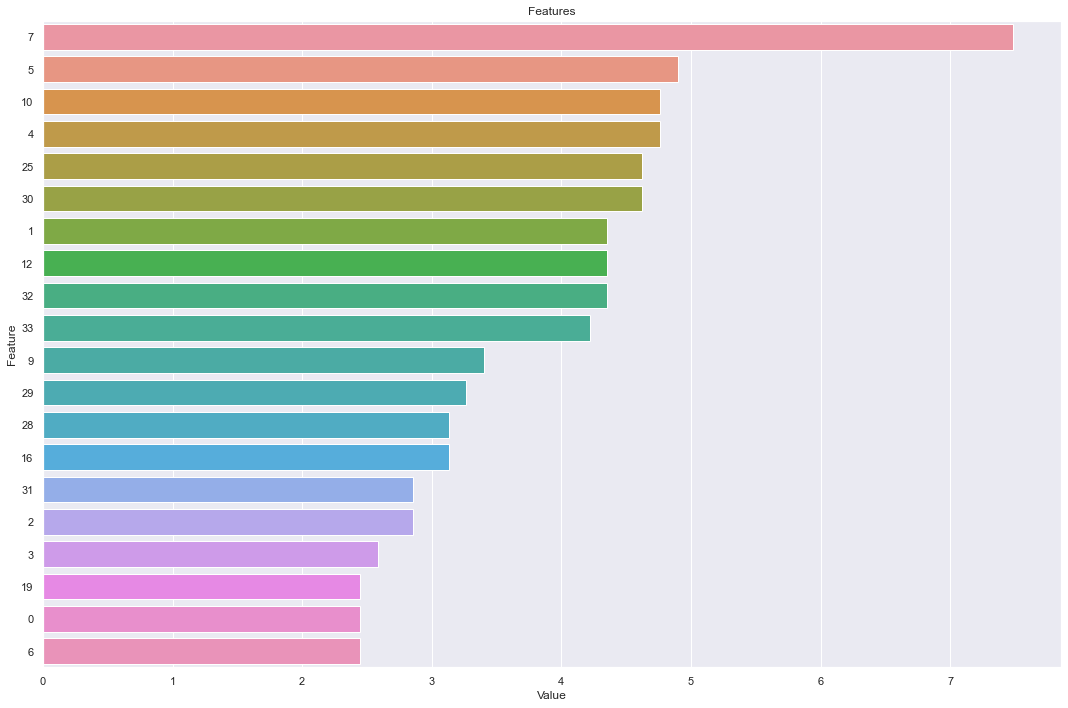

In [130]:
visualize_feature_importance(lgbm_final, X, save=1)